In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim,os,sklearn,tqdm

from collections import Counter
from datetime import datetime

from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim import models

# %matplotlib inline

C:\Users\Evan\AppData\Local\conda\conda\envs\env_futures\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
counter_dir="C:/Users/Evan/MyFile/Fortune-street/007 oil_price/oilprice_news_analyze/002 data/003 outcome_data/word_counter_data/"
txt_dir="C:/Users/Evan/MyFile/Fortune-street/007 oil_price/oilprice_news_analyze/002 data/002 corpus_data/token_txt_data/"
# C:\Users\Evan\MyFile\Fortune-street\007 oil_price\oilprice_news_analyze\002 data\002 corpus_data\token_txt_data

list_counter_filenames=list(os.walk(counter_dir))[0][2]
print(list_counter_filenames)
list_txt_source=list(os.walk(txt_dir))[0][1]
print(list_txt_source)
def read_news_txt_file(aFilepath):
    token_list=[]
    with open(aFilepath,"r",encoding='utf8') as f:
        news_title=f.readline()
        line = news_title
        while line :
            line = f.readline()
            token_list.append(line.strip())
    return(news_title,token_list)
full_list=[]
for aSource in list_txt_source:
    for subpath , null , list_news_filenames in tqdm.tqdm(list(os.walk(txt_dir+aSource))[1:]):
        news_publish_date=subpath.split("\\")[1]
        source=subpath.split("\\")[0].split("/")[-1]
        for aFilename in list_news_filenames:
            aFilepath="/".join([subpath, aFilename])
            news_title,news_tokens_list=(read_news_txt_file(aFilepath))
            
            out_dict={'news_publish_date':news_publish_date,
                      'news_title':news_title,
                      'news_tokens_list':news_tokens_list,
                      'source':source}
            full_list.append(out_dict)
full_news_df=pd.DataFrame(full_list)
full_news_df.head(10)

['word_counter.npy', 'word_counter_2019_02_08.npy', 'word_counter_2019_02_12.npy', 'word_counter_2019_02_26.npy']
['cnbc_news_data', 'oil_price_news_data', 'uk_reuters_news_data']


100%|██████████| 373/373 [01:50<00:00,  3.36it/s]


,news_publish_date,news_title,news_tokens_list,source
0,2018-12-04,update 3-oil prices skid with global stock mar...,"[singapore, dec, reuters, oil, prices, slumped...",cnbc_news_data
1,2018-12-04,u.s. oil prices slide with global markets on e...,"[singapore, dec, reuters, oil, prices, slipped...",cnbc_news_data
2,2018-12-04,heating oil futures turn negative in post-sett...,"[heating, oil, futures, turn, negative, in, tr...",cnbc_news_data
3,2018-12-04,oil futures fall in post-settlement trade afte...,"[oil, futures, fall, in, trade, after, api, da...",cnbc_news_data
4,2018-12-05,update 1-oil prices dip as stock markets slide...,"[opec, meeting, singapore, dec, reuters, oil, ...",cnbc_news_data
5,2018-12-05,oil prices ease in cautious trading ahead of o...,"[singapore, dec, reuters, oil, prices, dipped,...",cnbc_news_data
6,2018-12-05,"oil prices extend gains, brent crude up by mor...","[oil, prices, extend, gains, brent, crude, up,...",cnbc_news_data
7,2018-12-05,update 5-oil prices fall on global growth conc...,"[singapore, dec, reuters, oil, prices, fell, o...",cnbc_news_data
8,2018-12-05,update 4-oil prices slip on global growth conc...,"[singapore, dec, reuters, oil, prices, fell, o...",cnbc_news_data
9,2018-12-06,"oil firms on drop in us crude stocks, market a...","[decision, singapore, dec, reuters, oil, price...",cnbc_news_data


In [3]:
first_date=full_news_df.news_publish_date.unique()[0]
first_date

'2018-12-04'

In [4]:
full_history_df=pd.read_csv("C:\\Users\\Evan\\MyFile\\Fortune-street\\007 oil_price\
\\oilprice_news_analyze\\002 data\\001 price_data\\crude_oil_price\\Crude Oil WTI Futures Historical Data.csv")
full_history_df.Date=pd.DatetimeIndex(full_history_df.Date)
full_history_df.columns=["Date","Price","Open","High","Low","volume","change_percentage"]
full_history_df=full_history_df[::-1]
full_history_df=full_history_df.set_index("Date",drop=False)
history_since_news_df=full_history_df.loc[first_date:]
history_since_news_df.head()
history_since_news_df.to_csv("C:\\Users\\Evan\\MyFile\\Fortune-street\\007 oil_price\
\\oilprice_news_analyze\\002 data\\001 price_data\\crude_oil_price\\Crude Oil WTI Futures Historical Data_haha.csv")

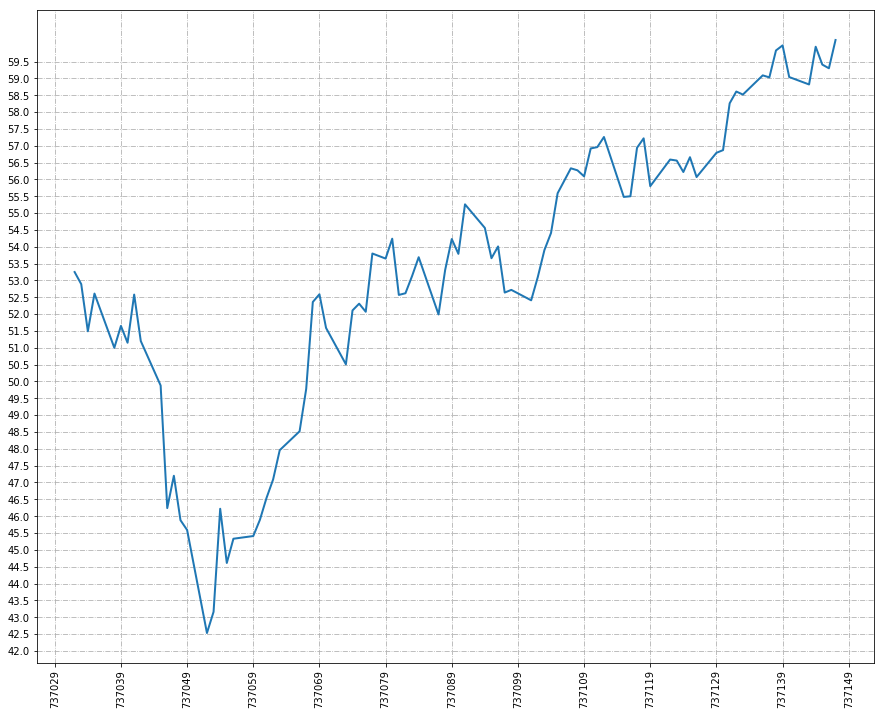

In [5]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
fig=plt.figure(figsize=(15,12))
xt=pd.Series(pd.date_range("2018-12-01","2019-03-31",freq="10D")).apply(pd.to_datetime)
plt.xticks(xt,rotation=90)
plt.yticks(np.arange(42,60,0.5))
plt.plot(history_since_news_df.loc[:,"Date"],history_since_news_df.loc[:,"Price"],linewidth=2)
plt.grid(True,linestyle='-.')
plt.show()

In [6]:
full_news_df.loc[:,'news_publish_date']=pd.DatetimeIndex(full_news_df.loc[:,'news_publish_date'])
def get_news_by_date(start,end=None):
    START=start
    if not end:
        END=START
    else:
        END=end
    out=full_news_df.loc[full_news_df['news_publish_date']>=START,:]
    out=out.loc[out['news_publish_date']<=END,:]
    return(out)
get_news_by_date("2018-03-12")

,news_publish_date,news_title,news_tokens_list,source
2904,2018-03-12,corrected-u.s. epa grants bankrupt philadelphi...,"[epa, grants, bankrupt, philadelphia, refiner,...",uk_reuters_news_data
2905,2018-03-12,update 1-u.s. northeast braces for third power...,"[reuters, the, third, nor, easter, to, hit, pa...",uk_reuters_news_data
2906,2018-03-12,update 2-colombia peso rallies after duque's s...,"[bogota, reuters, a, significant, lead, in, vo...",uk_reuters_news_data
2907,2018-03-12,german power deal sets template for eu utiliti...,"[utilities, increasingly, focus, on, one, busi...",uk_reuters_news_data
2908,2018-03-12,update 1-colombia's santos says will restart t...,"[bogota, reuters, colombia, and, the, marxist,...",uk_reuters_news_data
2909,2018-03-12,update 1-strike delays loading at libya's zawi...,"[adds, details, march, reuters, a, strike, by,...",uk_reuters_news_data
2910,2018-03-12,negotiations under way to end strike at libyan...,"[march, reuters, a, strike, by, workers, at, t...",uk_reuters_news_data
2911,2018-03-12,update 1-tillerson says several steps needed f...,"[adds, details, quotes, abuja, march, reuters,...",uk_reuters_news_data
2912,2018-03-12,"global markets-oil prices fall, but stocks kee...","[oil, prices, down, treasuries, hover, near, h...",uk_reuters_news_data
2913,2018-03-12,tillerson says several steps needed for u.s. t...,"[nigeria, tillerson, says, has, not, heard, an...",uk_reuters_news_data


C:\Users\Evan\AppData\Local\conda\conda\envs\env_futures\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


['change_percentage'].abs().mean() 1.6206976744186046
['change_percentage'].abs().std() 1.468391509499765


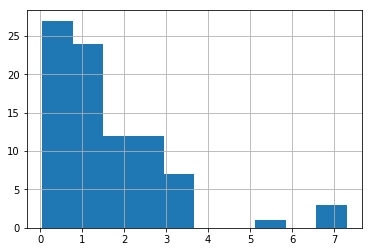

In [7]:
if type(history_since_news_df['change_percentage'][0])==str:
    history_since_news_df['change_percentage']=history_since_news_df['change_percentage'].apply(lambda x :float(x[:-1]))
print("['change_percentage'].abs().mean()",history_since_news_df['change_percentage'].abs().mean())
print("['change_percentage'].abs().std()",history_since_news_df['change_percentage'].abs().std())
history_since_news_df['change_percentage'].abs().hist()

86


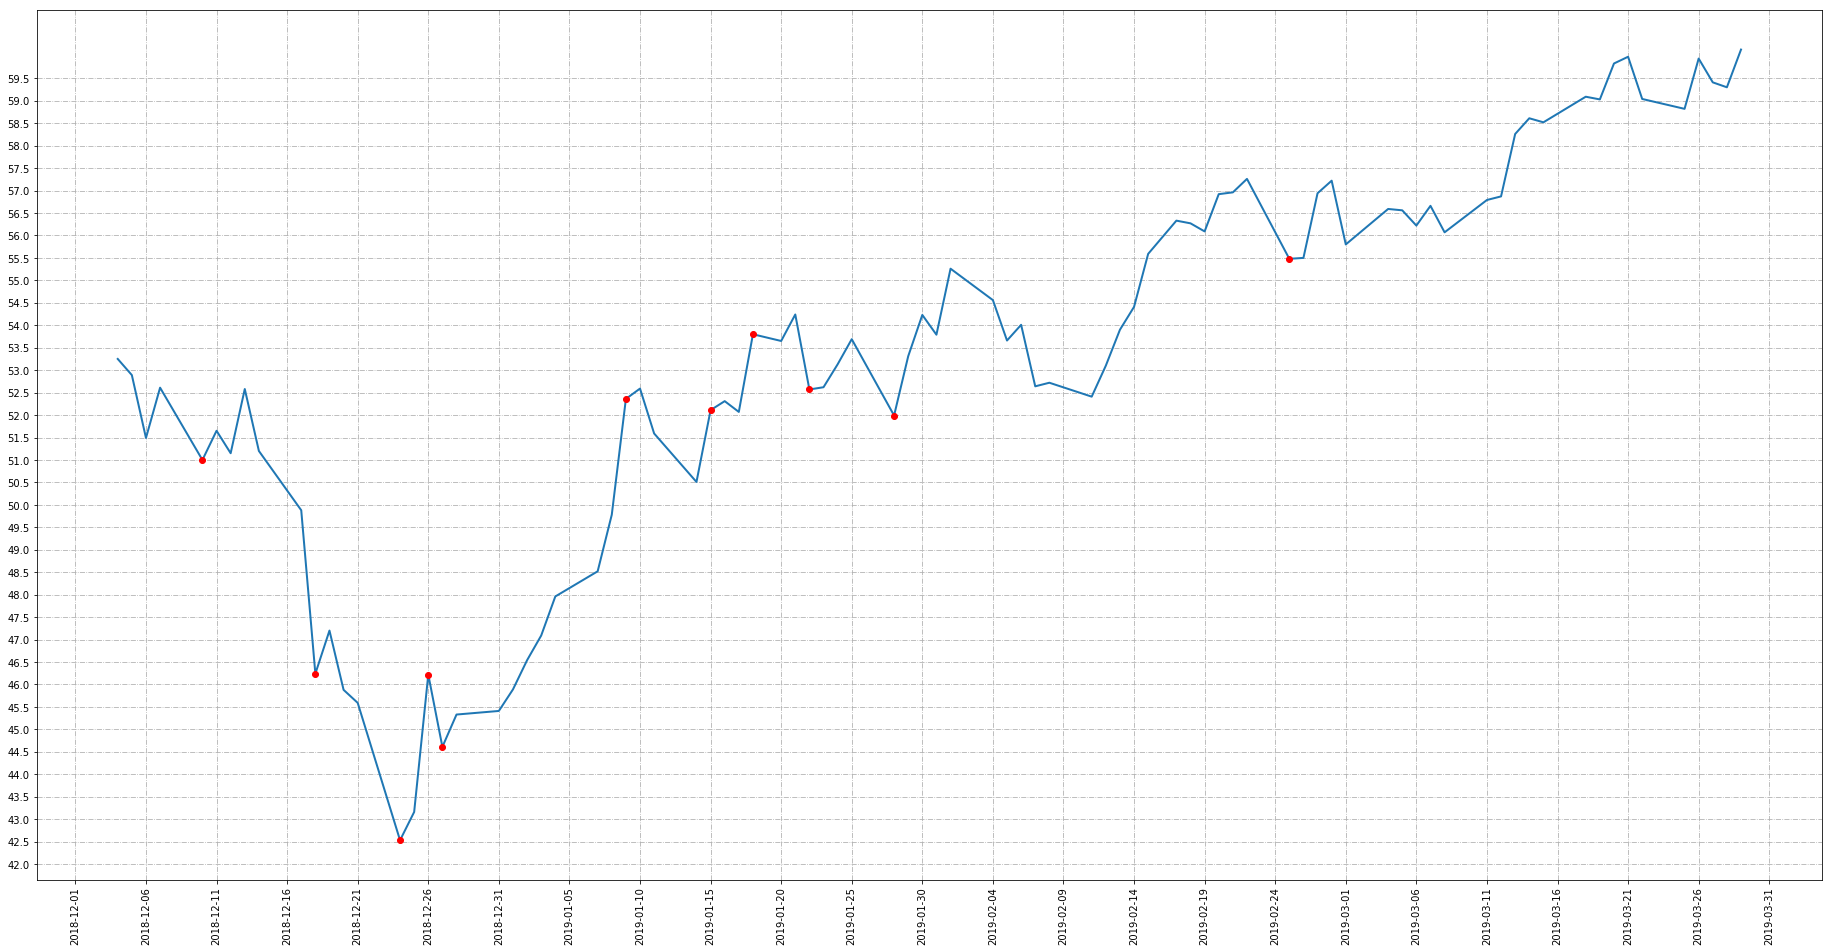

<Figure size 432x288 with 0 Axes>

In [8]:
print(history_since_news_df['change_percentage'].count())
big_change_date=history_since_news_df.loc[history_since_news_df['change_percentage'].abs()>3].index

from pandas.plotting import register_matplotlib_converters
import matplotlib.dates as mdates

fig=plt.figure(figsize=(32,16))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator())
register_matplotlib_converters()


xt=pd.Series(pd.date_range("2018-12-01","2019-03-31",freq="5D")).apply(pd.to_datetime)
plt.xticks(xt,rotation=90)
plt.yticks(np.arange(42,60,0.5))
plt.plot(history_since_news_df.loc[:,"Date"],history_since_news_df.loc[:,"Price"],linewidth=2)
plt.plot(history_since_news_df.loc[big_change_date,"Price"],"or")

plt.grid(True,linestyle='-.')
plt.show()
plt.savefig("./big_change.png")

In [9]:
history_since_news_df["2018-12-21":"2018-12-26"]

,Date,Price,Open,High,Low,volume,change_percentage
Date,,,,,,,
2018-12-21,2018-12-21,45.59,46.25,46.77,45.13,694.00K,-0.63
2018-12-24,2018-12-24,42.53,45.45,46.24,42.36,415.86K,-6.71
2018-12-25,2018-12-25,43.16,43.00,43.25,42.88,-,1.48
2018-12-26,2018-12-26,46.22,42.85,47.00,42.52,698.41K,7.09


In [39]:
xxx=get_news_by_date(big_change_date[0])
xxxt=xxx.news_title
xxxtr=xxxt.reset_index(drop=True)
xxxtr[3]
i=0

In [51]:
print(xxxtr[i])
i+=1

saudi arabia to cut oil exports by 1 million bpd next month

